In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import os

In [2]:
import wfdb
from wfdb import processing

In [3]:
import reconstructionutils as ru
import stanpy_orig as sp

In [4]:
# read all signals of db in

signals = []
    
path = 'cebsdb/'
        
for el in os.scandir(path):
    if el.is_file():
        if el.name.endswith('.hea'):
            signals.append(
                wfdb.rdrecord(path + el.name[:-4])
            )

In [5]:
# index was selected by hand
series = signals[0].p_signal.T

<IPython.core.display.Javascript object>


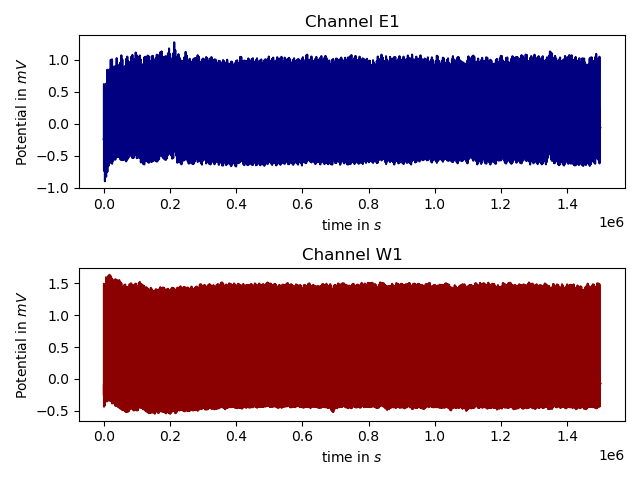

In [6]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.title('Channel E1')
plt.plot(series[0], label='Channel E1', c='navy')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.subplot(2, 1, 2)
plt.title('Channel W1')
plt.plot(series[1], label='Channel W1', c='darkred')
plt.xlabel('time in $s$')
plt.ylabel('Potential in $mV$')
plt.tight_layout()
plt.show()

In [7]:
series = [
    series[0],
    series[1],
]

<IPython.core.display.Javascript object>


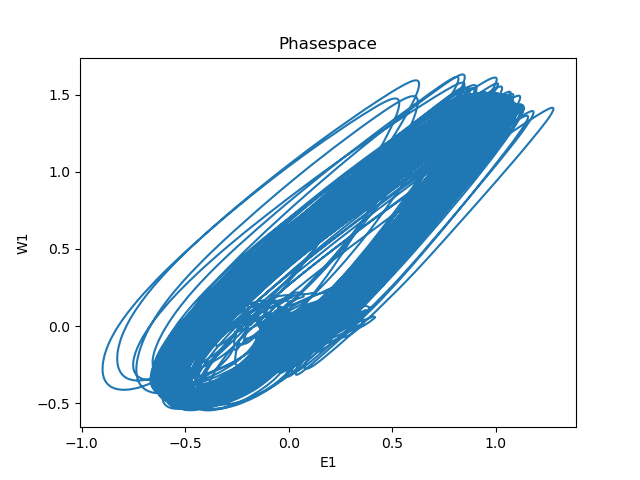

In [8]:
%matplotlib notebook
plt.plot(series[0], series[1])
plt.title('Phasespace')
plt.xlabel('E1')
plt.ylabel('W1')
plt.show()

# PRSA

In [9]:
def condition(series, current_index, threshold=.75):
    '''Returns True if series[current_index] should be used as an achor point'''
    if series[current_index] >= threshold and series[current_index + 2] < series[current_index] \
        > series[current_index - 2]:
        return True
    return False

In [10]:
anchors = []

In [11]:
for i in range(len(series[0])):
    if condition(series[0], i):
        anchors.append(i)

<IPython.core.display.Javascript object>


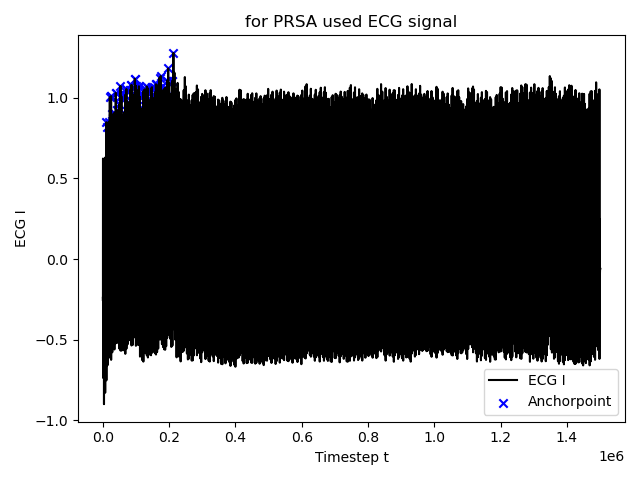

In [12]:
%matplotlib notebook
plt.plot(series[0], c='black', label='ECG I')
plt.scatter(anchors[:100], [series[0][i] for i in anchors][:100], marker='x', c='b', label='Anchorpoint')
plt.title('for PRSA used ECG signal')
plt.xlabel('Timestep t')
plt.ylabel('ECG I')
#plt.xlim([0, .1])
plt.tight_layout()
plt.legend()
plt.show()

In [13]:
# get the average length of a heartbeat in timesteps
average_heartbeat_duration = np.mean(np.setdiff1d(np.roll(anchors, -1)[:-1] - anchors[:-1], [1]))

In [14]:
print(average_heartbeat_duration)

3131.103975535168


In [15]:
#window = 5500 // 2
window = 3131 // 2

<IPython.core.display.Javascript object>


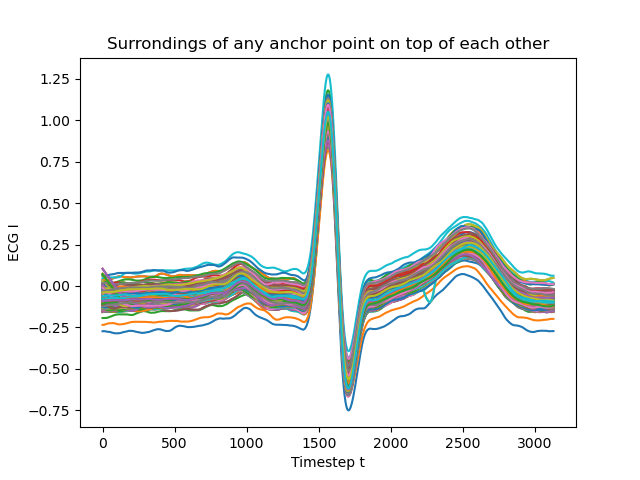

In [16]:
%matplotlib notebook
for el in anchors:
    plt.plot(series[0][el - window:el + window])
plt.title('Surrondings of any anchor point on top of each other')
plt.xlabel('Timestep t')
plt.ylabel('ECG I')
plt.show()

In [17]:
# Perform signal averaging
def prsa(series, anchors, window):
    m = int(2 * window)
    
    series_surroundings = []
    for el in anchors:
        series_surroundings.append(series[el - window:el + window])
    series_surroundings = np.asarray(series_surroundings)
        
    summed = []
    for i in range(m):
        summed.append(np.sum(series_surroundings.T[i]))
            
    summed_mean = [(1 / m) * el for el in summed]
    
    def _f(k, summed_mean=summed_mean):
        return summed_mean[k]
    
    return _f

In [18]:
x = prsa(series[0], anchors, window)

In [19]:
y = prsa(series[1], anchors, window)

<IPython.core.display.Javascript object>


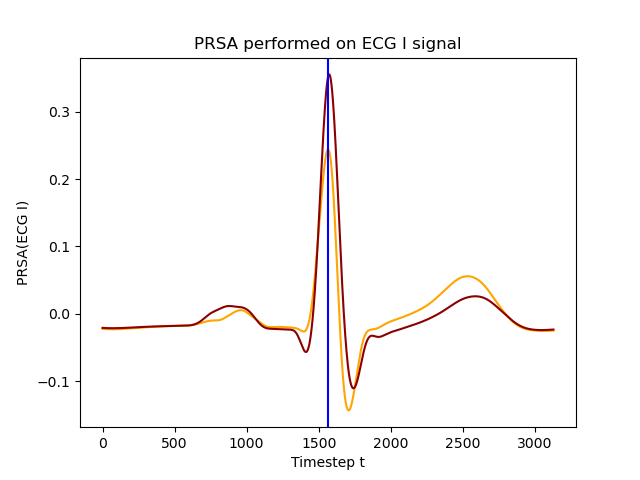

In [20]:
%matplotlib notebook
plt.plot([x(k) for k in range(2 * window)], c='orange')
plt.plot([y(k) for k in range(2 * window)], c='darkred')
plt.axvline(window, c='b')
plt.title('PRSA performed on ECG I signal')
plt.xlabel('Timestep t')
plt.ylabel('PRSA(ECG I)')
plt.show()

## shift ECG time series E1

In [21]:
x_ = [x(k) for k in range(2 * window)]
y_ = [y(k) for k in range(2 * window)]

In [22]:
len(x_)

3130

<IPython.core.display.Javascript object>


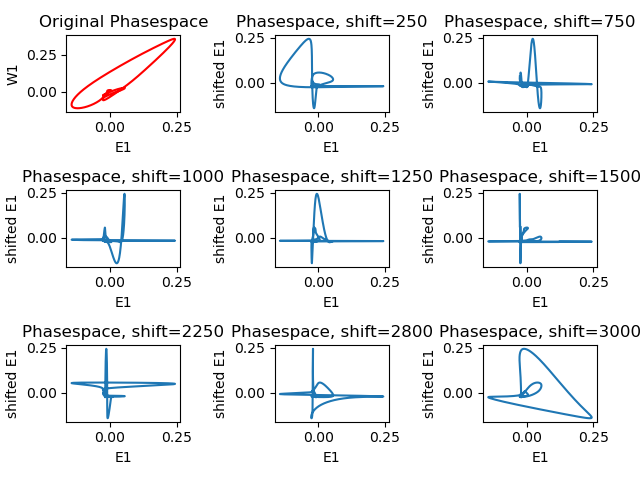

In [23]:
%matplotlib notebook
plt.subplot(3, 3, 1)
plt.plot(x_, y_, c='r')
plt.title('Original Phasespace')
plt.xlabel('E1')
plt.ylabel('W1')

index = 1
for shift in [250, 750, 1000, 1250, 1500, 2250, 2800, 3000]:
    plt.subplot(3, 3, 1 + index)
    plt.plot(x_, np.roll(x_, shift))
    plt.title('Phasespace, shift=%i' % (shift))
    plt.xlabel('E1')
    plt.ylabel('shifted E1')
    index += 1

plt.tight_layout()
plt.show()

In [24]:
import matplotlib.animation as animation

<IPython.core.display.Javascript object>


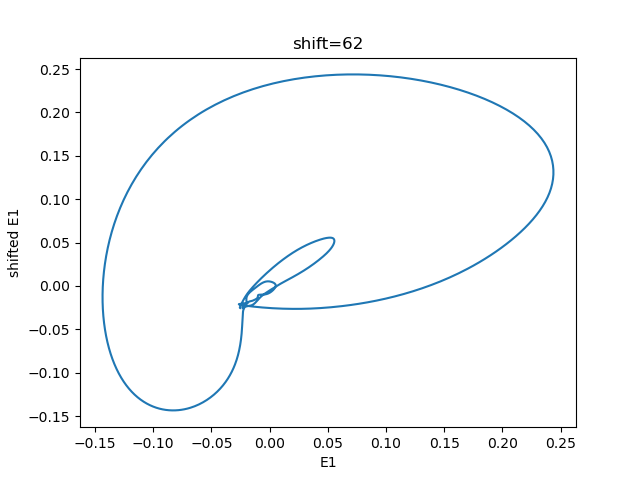

In [25]:
fig, ax = plt.subplots()

step = 2

def animate(i):
    shift = step * i  # 3130
    fig.clear()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('shift=%i'%(shift))
    ax.plot(x_, np.roll(x_, shift))
    ax.set_xlabel('E1')
    ax.set_ylabel('shifted E1')
    
interval = 50
ani = animation.FuncAnimation(fig, animate, interval=interval, blit=False, frames=len(x_)//step, repeat_delay=2500)

plt.show()

In [26]:
shift = 60
shifted_series = np.roll(x_, shift)

<IPython.core.display.Javascript object>


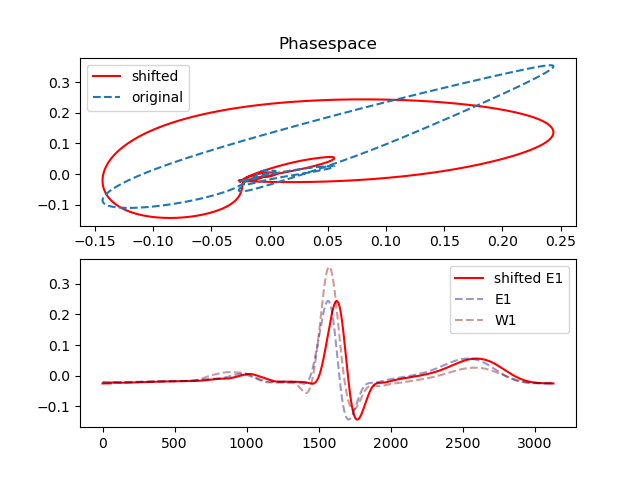

In [27]:
%matplotlib notebook
plt.subplot(2, 1, 1)
plt.plot(x_, shifted_series, label='shifted', c='r')
plt.plot(x_, y_, label='original', linestyle='--')
plt.legend()
plt.title('Phasespace')
plt.subplot(2, 1, 2)
plt.plot(shifted_series, label='shifted E1', c='r')
plt.plot(x_, label='E1', c='navy', linestyle='--', alpha=.4)
plt.plot(y_, label='W1', c='darkred', linestyle='--', alpha=.4)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


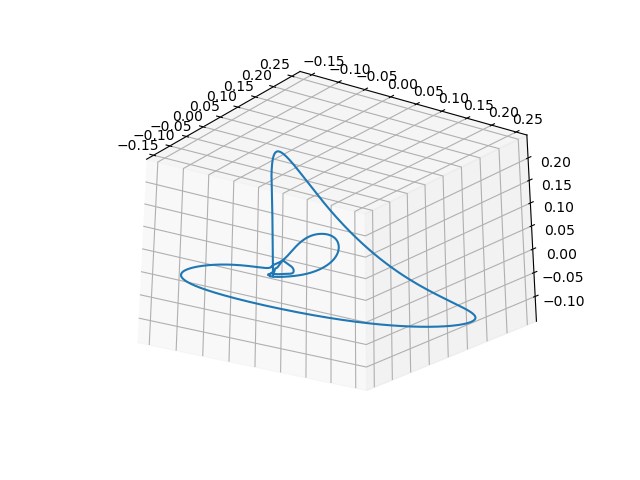

In [109]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot(x_, np.roll(x_, shift), np.roll(x_, 3000))
fig.show()

<IPython.core.display.Javascript object>


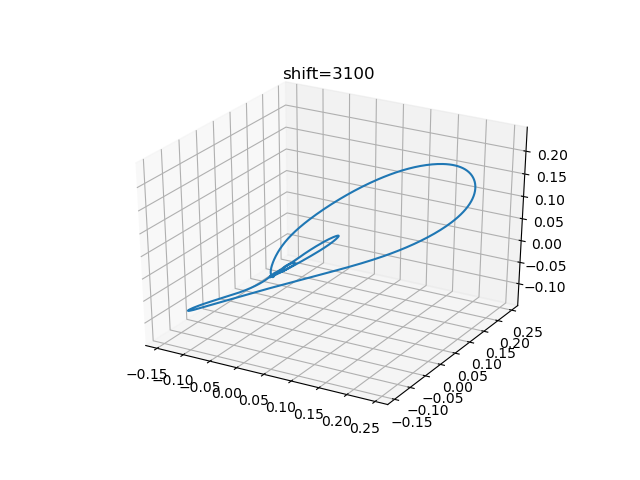

In [165]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

step = 10

def animate(i):
    shift = step * i  # 3130
    fig.clear()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot(x_, np.roll(x_, 60), np.roll(x_, shift))
    ax.set_title('shift=%i'%(shift))
    
interval = 50
ani = animation.FuncAnimation(fig, animate, interval=interval, blit=False, frames=len(x_)//step, repeat_delay=2500)

plt.show()

### reconstruct

In [204]:
system = ru.Model(series=[x_,
                          np.roll(x_, 60),
                          np.roll(x_, 3090),
                         ], 
                  grade=8, #8!
                  #derivate=[derivatives[0],
                  #          derivatives[1],
                  #          derivatives[2],
                  #         ],
                  #weighting=weighting
                 )

In [205]:
_ = system._create_model()

In [206]:
index_start = 0
ivp = [x_[index_start],
       np.roll(x_, 60)[index_start],
       np.roll(x_, 3090)[index_start],
      ]

t = np.linspace(index_start,
                len(x_),
                len(x_),
                )

sol, infodict = odeint(system.model,
                       ivp,
                       t,
                       args=(system.fit_functions,),
                       tfirst=True,
                       full_output=True,
                       printmessg=True)

c:\users\franz\appdata\local\programs\python\python38-32\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


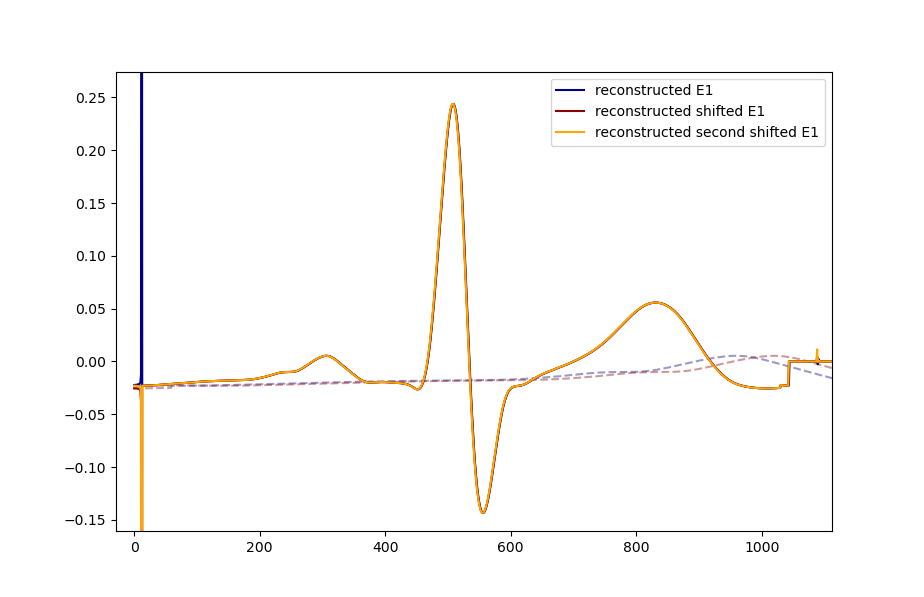

In [210]:
%matplotlib notebook
plt.plot(x_, c='navy', alpha=.4, linestyle='--')
plt.plot(shifted_series, c='darkred', alpha=.4, linestyle='--')
plt.plot(sol.T[0], c='navy', label='reconstructed E1')
plt.plot(sol.T[1], c='darkred', label='reconstructed shifted E1')
plt.plot(sol.T[2], c='orange', label='reconstructed second shifted E1')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


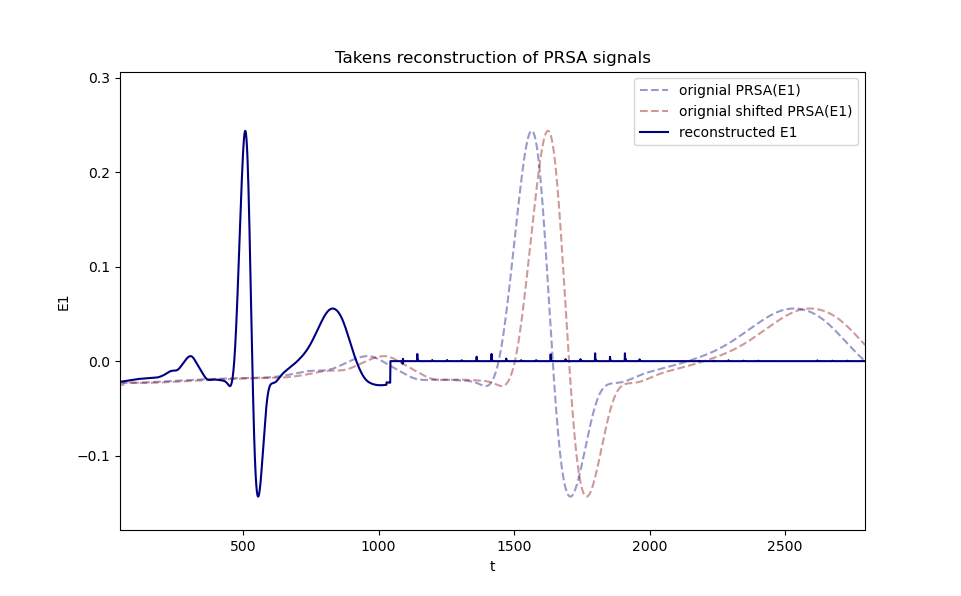

In [215]:
%matplotlib notebook
plt.plot(x_, c='navy', alpha=.4, linestyle='--', label='orignial PRSA(E1)')
plt.plot(shifted_series, c='darkred', alpha=.4, linestyle='--', label='orignial shifted PRSA(E1)')
plt.plot(sol.T[0], c='navy', label='reconstructed E1')
#plt.plot(sol.T[1], c='darkred')
plt.xlabel('t')
plt.ylabel('E1')
plt.title('Takens reconstruction of PRSA signals')
plt.legend()
plt.show()

## stochastic analysis

In [296]:
analysis = sp.StochasticAnalysis([series[0], shifted_series])

In [304]:
analysis.analyze(dt=1)

IndexError: index 258 is out of bounds for axis 1 with size 250